# 1. Data download and exploratory analysis

In [ ]:
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1.1. Download and parse data

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Pet_Supplies.json.gz

--2023-09-03 23:01:31--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Pet_Supplies.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 901468015 (860M) [application/x-gzip]
Saving to: ‘Pet_Supplies.json.gz.1’

Pet_Supplies.json.g 100%[===================>] 859.71M  49.6MB/s    in 17s     

2023-09-03 23:01:49 (49.1 MB/s) - ‘Pet_Supplies.json.gz.1’ saved [901468015/901468015]



In [ ]:
def parse(path):
  f = gzip.open(path, 'rb')
  for l in f:
    yield json.loads(l.strip())

In [ ]:
data = [{'overall': review.get('overall'),
         'reviewText': review.get('reviewText')}
        for review in parse('Pet_Supplies.json.gz')]

In [ ]:
# Convert list into pandas dataframe
reviews_df = pd.DataFrame.from_dict(data)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6542483 entries, 0 to 6542482
Data columns (total 2 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   reviewText  object 
dtypes: float64(1), object(1)
memory usage: 99.8+ MB


In [ ]:
reviews_df.isna().sum()

overall          0
reviewText    3796
dtype: int64

In [ ]:
# Drop NaNs
reviews_df.dropna(inplace=True)
print(f'Total reviews: {reviews_df.shape[0]:,}')

Total reviews: 6,538,687


In [ ]:
# Reviews frequency distribution
freq = reviews_df['overall'].value_counts().sort_index()
freq / len(reviews_df)

1.00   0.10
2.00   0.06
3.00   0.08
4.00   0.13
5.00   0.64
Name: overall, dtype: float64

## 1.2. Undersampling and encoding

In [ ]:
# Undersampling
neg_reviews_pcg = 0.01
neg_reviews = round(freq.filter([1, 2]) * neg_reviews_pcg)
pos_reviews = round(freq.filter([4, 5]) / sum(freq.filter([4, 5])) * sum(neg_reviews))
n_samples = pd.concat([neg_reviews, pos_reviews])

ureviews_df = pd.DataFrame()
for idx in n_samples.index:
  undersampled_df = reviews_df[reviews_df['overall'] == idx].sample(int(n_samples[idx]), random_state=0)
  ureviews_df = pd.concat([ureviews_df, undersampled_df])

ureviews_df['overall'].value_counts().sort_index()

1.00    6417
2.00    3729
4.00    1713
5.00    8433
Name: overall, dtype: int64

In [ ]:
# Dummy encoding {'*': 0, '**': 0, '****': 1, '*****': 1}
ureviews_df['sentiment'] = ureviews_df['overall'].map(lambda stars: 0 if stars < 3 else 1)
ureviews_df.drop(['overall'], axis=1, inplace=True)

## 1.3. Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
reviews_train_df, reviews_test_df = train_test_split(ureviews_df, test_size=0.2, random_state=0)

print(f"Train shape: {reviews_train_df.shape}")
print(f"Test shape: {reviews_test_df.shape}")

Train shape: (16233, 2)
Test shape: (4059, 2)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p '/content/drive/MyDrive/nlp/amazon/data/'

In [ ]:
# Save train and test dataframes
base_path = '/content/drive/MyDrive/nlp/amazon'
reviews_train_df.to_csv(base_path + '/data/pet_supplies_train.csv', index=False)
reviews_test_df.to_csv(base_path + '/data/pet_supplies_test.csv', index=False)

In [ ]:
del data, reviews_df

## 1.4. Descriptive Statistics

In [3]:
# Negative reviews statistics (tokens/review)
neg_reviews = reviews_train_df[reviews_train_df['sentiment'] == 0]['reviewText'].map(lambda r: r.lower().split())
neg_reviews.map(lambda l: len(l)).describe()

count    8103.000000
mean       48.533506
std        63.754871
min         0.000000
25%        15.000000
50%        31.000000
75%        60.000000
max      2518.000000
Name: reviewText, dtype: float64

In [4]:
# Positive reviews statistics (tokens/review)
pos_reviews = reviews_train_df[reviews_train_df['sentiment'] == 1]['reviewText'].map(lambda r: r.lower().split())
pos_reviews.map(lambda l: len(l)).describe()

count    8130.000000
mean       42.611439
std        62.691591
min         1.000000
25%         9.000000
50%        24.000000
75%        51.000000
max      1387.000000
Name: reviewText, dtype: float64

In [7]:
negreviews_tokens = [tk for review in neg_reviews for tk in review]
posreviews_tokens = [tk for review in pos_reviews for tk in review]
reviews_tokens = negreviews_tokens + posreviews_tokens

total_tokens = len(reviews_tokens)
cardinality = len(set(reviews_tokens))

print(f'Total tokens: {total_tokens:,}')
print(f'Vocabulary cardinality: {cardinality:,}')
print(f'Lexical richness: {cardinality / total_tokens:.4f}')

Total tokens: 739,698
Vocabulary cardinality: 37,754
Lexical richness: 0.0510


In [ ]:
!pip install nltk

In [8]:
import nltk

# Words frequency distribution with punctuation marks and stopwords
words_fdist = nltk.FreqDist(reviews_tokens)
words_fdist.tabulate(15)

  the     i   and    to    it     a    my  this    is   for    of    in   not   was    on 
34300 20346 20311 18767 16978 16977 11203 10897 10126  9898  9893  7574  6740  6074  5828 


In [9]:
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

# Remove punctuation marks and stopwords
def remove_punctuationmarks(tokens, punctuation):
  return [tk.translate(str.maketrans('', '', punctuation)) for tk in tokens if tk not in punctuation]

def remove_stopwords(words, stopwords):
  return [w for w in words if w not in stopwords]

def clean_text(tokens, punctuation=string.punctuation, stopwords=stopwords.words('english')):
  words = remove_punctuationmarks(tokens, punctuation)
  return remove_stopwords(words, stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Words frequency distribution of negative reviews
negreviews_words = clean_text(negreviews_tokens)
negreviews_words_fdist = nltk.FreqDist(negreviews_words)
negreviews_words_fdist.tabulate(15)

    dog     one   would product    like     cat     get    dogs    work   small    even    dont   didnt     use    time 
   2812    1910    1800    1699    1359    1208    1110    1079    1035     957     932     915     911     904     897 


In [ ]:
# Words frequency distribution of positive reviews
posreviews_words = clean_text(posreviews_tokens)
posreviews_words_fdist = nltk.FreqDist(posreviews_words)
posreviews_words_fdist.tabulate(15)

    dog   great    love     one    dogs     cat product    like    good   would   loves    well     get    food    cats 
   2507    2213    1661    1599    1385    1346    1325    1257    1194    1142    1137    1129    1008     987     942 


In [ ]:
# Words frequency distribution of all reviews
reviews_words = negreviews_words + posreviews_words
reviews_words_fdist = nltk.FreqDist(reviews_words)
reviews_words_fdist.tabulate(15)

    dog     one product   would   great    like     cat    dogs     get    love    good     use    well    food    cats 
   5319    3509    3024    2942    2763    2616    2554    2464    2118    1915    1894    1791    1777    1764    1753 


In [ ]:
del ureviews_df, \
    negreviews_tokens, negreviews_words_fdist, \
    posreviews_tokens, posreviews_words_fdist, \
    words_fdist, reviews_words_fdist

## 1.5. N-grams

### 1.5.1. Bigrams

In [ ]:
# Top 10 negative reviews bigrams
negreviews_bigrams = list(nltk.ngrams(negreviews_words, 2))
negreviews_bigrams_fdist = nltk.FreqDist(negreviews_bigrams)
negreviews_bigrams_fdist.most_common(10)

[(('waste', 'money'), 335),
 (('didnt', 'work'), 165),
 (('would', 'recommend'), 136),
 (('doesnt', 'work'), 129),
 (('litter', 'box'), 118),
 (('first', 'time'), 115),
 (('year', 'old'), 109),
 (('small', 'dog'), 103),
 (('dont', 'waste'), 99),
 (('dont', 'know'), 93)]

In [ ]:
# Top 10 positive reviews bigrams
posreviews_bigrams = list(nltk.ngrams(posreviews_words, 2))
posreviews_bigrams_fdist = nltk.FreqDist(posreviews_bigrams)
posreviews_bigrams_fdist.most_common(10)

[(('dog', 'loves'), 297),
 (('works', 'great'), 261),
 (('great', 'product'), 257),
 (('dogs', 'love'), 204),
 (('highly', 'recommend'), 196),
 (('cats', 'love'), 175),
 (('well', 'made'), 151),
 (('works', 'well'), 142),
 (('cat', 'loves'), 134),
 (('litter', 'box'), 127)]

### 1.5.2. Trigrams

In [ ]:
# Top 10 negative reviews trigram
negreviews_trigrams = list(nltk.ngrams(negreviews_words, 3))
negreviews_trigrams_fdist = nltk.FreqDist(negreviews_trigrams)
negreviews_trigrams_fdist.most_common(10)

[(('dont', 'waste', 'money'), 78),
 (('would', 'recommend', 'product'), 25),
 (('total', 'waste', 'money'), 25),
 (('local', 'pet', 'store'), 24),
 (('month', 'old', 'puppy'), 19),
 (('complete', 'waste', 'money'), 19),
 (('waste', 'time', 'money'), 18),
 (('within', '5', 'minutes'), 17),
 (('dont', 'waste', 'time'), 17),
 (('first', 'time', 'used'), 17)]

In [ ]:
# Top 10 positive reviews trigram
posreviews_trigrams = list(nltk.ngrams(posreviews_words, 3))
posreviews_trigrams_fdist = nltk.FreqDist(posreviews_trigrams)
posreviews_trigrams_fdist.most_common(10)

[(('easy', 'put', 'together'), 44),
 (('would', 'highly', 'recommend'), 34),
 (('highly', 'recommend', 'product'), 30),
 (('last', 'long', 'time'), 26),
 (('great', 'product', 'great'), 25),
 (('would', 'definitely', 'recommend'), 25),
 (('love', 'love', 'love'), 22),
 (('would', 'recommend', 'anyone'), 19),
 (('would', 'recommend', 'product'), 18),
 (('worth', 'every', 'penny'), 17)]

In [ ]:
del negreviews_bigrams, negreviews_bigrams_fdist, \
    posreviews_bigrams, posreviews_bigrams_fdist, \
    negreviews_trigrams, negreviews_trigrams_fdist, \
    posreviews_trigrams, posreviews_trigrams_fdist

## 1.6. Word Clouds

In [ ]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

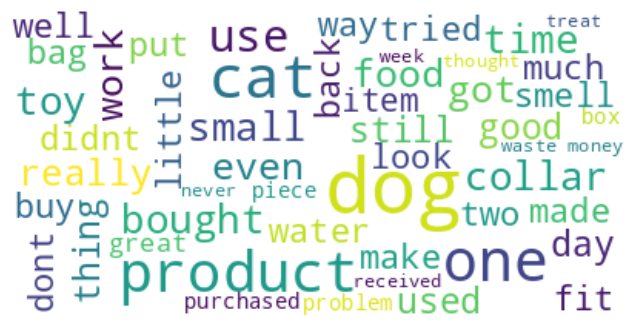

In [ ]:
# Negative reviews
plot_word_cloud(negreviews_words)

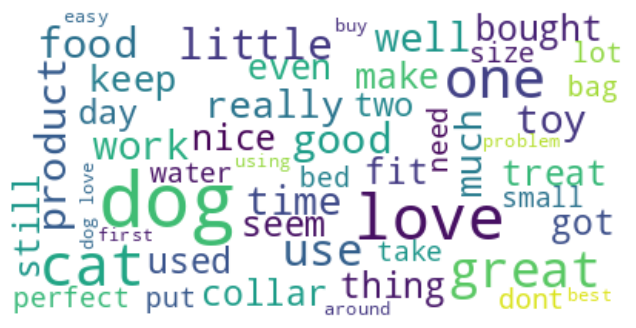

In [ ]:
# Positive reviews
plot_word_cloud(posreviews_words)

## 1.7. Word Embeddings Visualization

In [10]:
from functools import reduce
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

reviews = pd.concat([pos_reviews, neg_reviews]).map(clean_text)
w2v_model = Word2Vec(sentences=reviews, vector_size=100, window=5, min_count=5, workers=4)

# Target words
words = ['dog', 'cat', 'collar', 'food', 'problem']

# Top 5 most similar words
simwords = [[word] + [w for w, _ in w2v_model.wv.most_similar(word, topn=5)] for word in words]

# Embeddings
ws = reduce(lambda x, y: x + y, simwords)
embeddings = w2v_model.wv[ws]

# PCA
pca = PCA(n_components=2)
pcomponents = pca.fit_transform(embeddings)

In [11]:
!pip install adjustText

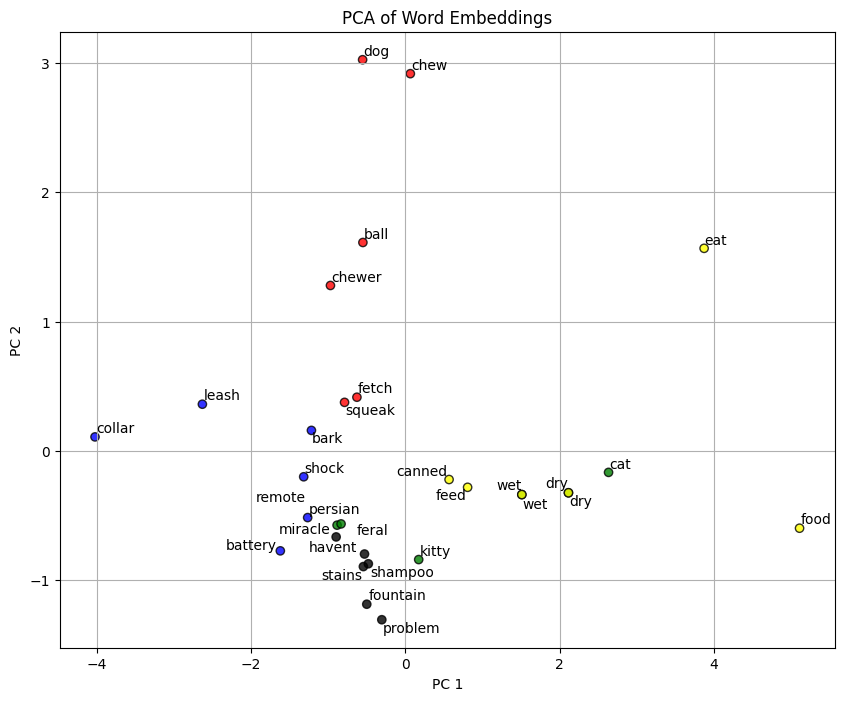

In [12]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

plt.figure(figsize=(10, 8))
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'black'}
markers =  {0: 'o', 1: '*', 2: 'P', 3: '^', 4: 's'}
x, y = pcomponents[:, 0], pcomponents[:, 1]
plt.scatter(x, y, c=[colors[i // 6] for i in range(30)], edgecolors='black', lw=1, alpha=0.8)

texts = [plt.text(x[i], y[i], w) for i, w in enumerate(ws)]
adjust_text(texts)

plt.title('PCA of Word Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()

## 1.8. Comments

- Se considera que son positivas las reviews con 4 y 5 estrellas, y negativas las reviews con 1 y 2 estrellas.

- Debido a limitaciones de RAM en la fase de entrenamiento de los modelos, se ha decidido reducir el corpus objeto de análisis al $1\%$ del corpus original.

- Como el número de reviews positivas es significativamente mayor que el número de reviews negativas, se ha realizado un undersampling para balancear los datos conservando la distribución de reviews por estrella para cada sentimiento.

- Para hacer una mejor exploración de los datos se ha realizado un preprocesamiento preliminar eliminando signos de puntuación y stopwords.

- Las mascotas que más se mencionan son perros y gatos, se hace casi el doble de referencias a perros que a gatos en las reviews que se habla de estas mascotas.

- El producto que más se menciona es comida, otros productos a los que se hace referencia son: collar, recompensas para perros, juguetes, cama, caja para gatos, bolsa.

- En las reviews negativas las combinaciones de palabras más frecuentes son: pérdida de tiempo y dinero, no funciona, no lo recomendaría, primera vez.

- En las reviews positivas las combinaciones de palabras más frecuentes son: funciona muy bien, gran producto, muy recomendable, fácil de montar, le encanta a mi mascota.
